# Gaussian Regression in PyTorch

Gaussian regression uses a likelihood based on the Gaussian distribution.

The model that we'll fit is:

\begin{align*}
y_{i} &\sim \textrm{Normal}(\mu_{i}, \sigma^{2}) ~~~ \textrm{for}~ i=1, ..., N, \\
\mu_{i} &= \boldsymbol{x}_{i}^{\top} \boldsymbol{\beta}, 
\end{align*}

where 

* $y_{i}$ is the response of the $i\textrm{th}$ observation.
* $\boldsymbol{x}_{i}$ is the vector of covariate values for the $i\textrm{th}$ observation.
* $\boldsymbol{\beta}$ is the vector of effects for the fixed covariates.

The probability density function of the Gaussian distribution is:

\begin{align*}
f(y_{i}; \mu_{i}, \sigma) &= \frac{1}{\sigma\sqrt{2\pi}}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta})^2 \right)
\end{align*}

Thus, the likelihood is 

\begin{align*}
L(\mu_{i}, \sigma; y_{i}) &= \prod_{i=1}^{N} \sigma^{-1} (2\pi)^{-0.5}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta})^2 \right)
\end{align*}

The log-likelihood is 

\begin{align*}
\textrm{log}(L(\mu_{i}, \sigma; y_{i})) &= \sum_{i=1}^{N}\textrm{log} \left[ \sigma^{-1} (2\pi)^{-0.5}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta})^2 \right) \right] \\
&= - \sum_{i=1}^{N}\left[ \textrm{log}(\sigma) + 0.5 \textrm{log}(2\pi) + \frac{1}{2\sigma^{2}} (y_{i}-\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta})^2 \right]
\end{align*}

The negative log-likelihood is 

\begin{align*}
-\textrm{log}(L(\mu_{i}, \sigma; y_{i})) &= \sum_{i=1}^{N}\left[ \textrm{log}(\sigma) + 0.5 \textrm{log}(2\pi) + \frac{1}{2\sigma^{2}} (y_{i}-\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta})^2 \right]
\end{align*}

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from library.GaussianRegression import GaussianRegression

## Step 1: Generate synthetic data based on a linear model

In [2]:
# Set random seed for reproducibility
torch.manual_seed(123)

# y_i ~ N(X_i β, σ²)
n = 10000  # sample size
p = 5        # number of predictors (excluding intercept); change as needed

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: Choose random intercept and slopes (shape: (p+1, 1))
# Using standard normal draws (you can scale or shift as needed)
true_beta = torch.randn(p+1, 1)
true_sigma = 1.5  # standard deviation of the error term

# Generate response variable with noise (μ = Xβ, σ = true_sigma)
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)  # Add intercept column
mu = X_with_intercept @ true_beta  # μ = Xβ
epsilon = torch.randn(n, 1) * true_sigma  # ε ~ N(0, σ²)
y = mu + epsilon  # y = Xβ + ε

# Step 2: Instantiate model and optimizer

In [3]:
model = GaussianRegression(X)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Train the model

In [4]:
num_epochs = 3000
losses = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    # Compute negative log-likelihood
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop timer
print(f"Training completed in {elapsed_time:.2f} seconds")

Epoch [1000/3000], NLL: 40212.0781
Epoch [2000/3000], NLL: 31923.8711
Epoch [3000/3000], NLL: 26627.7109
Training completed in 2.69 seconds


# Step 4: Extract learned parameters

In [5]:
learned_beta = model.beta.data.flatten()
learned_sigma = model.sigma().item()

print(f'Learned parameters:')
print(f'β = {learned_beta.tolist()}')
print(f'σ = {learned_sigma:.4f}')
print(f'True parameters:')
print(f'β = {true_beta.flatten().tolist()}')
print(f'σ = {true_sigma:.4f}')

Learned parameters:
β = [-0.49656739830970764, -0.7261670827865601, -0.4242430627346039, 0.3784099221229553, -1.9232566356658936, -0.0924781858921051]
σ = 4.9042
True parameters:
β = [-0.6942135095596313, -0.48340314626693726, -0.530332624912262, 0.6093006134033203, -2.5594072341918945, 0.18734775483608246]
σ = 1.5000


# Step 5: Plot results

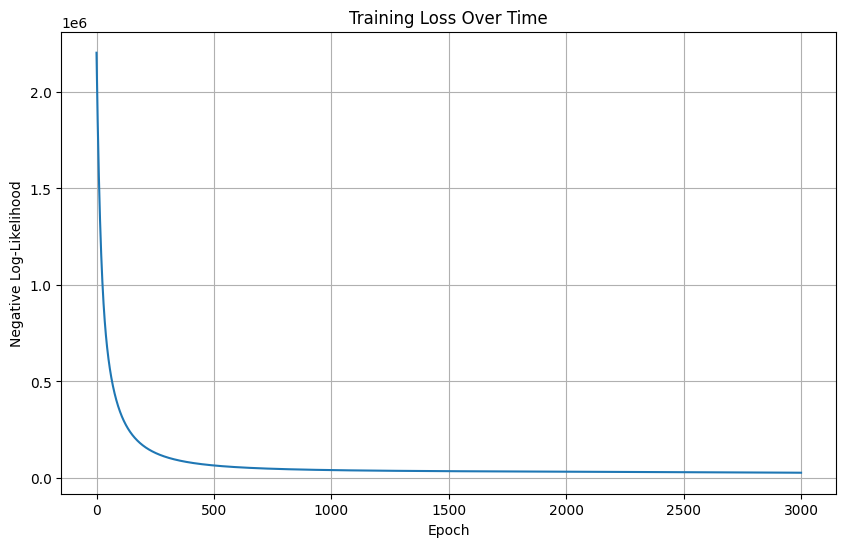

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()